# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 


1. Tools to find best iteration of your model
1. Visualize reward distribution on the track
 - Visualize reward heatmap per episode or iteration
1. Identify hotspots on the track for your model
1. Understand probability distributions on simulated images
1. Evaluation run analysis - plot lap speed heatmap


## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import boto3
import shutil
import os
import glob
import math
import tarfile
import requests
import json
import random
%matplotlib inline

In [2]:
!pip install shapely

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [4]:
from log_analysis import *
from os import listdir
from os.path import isfile, join


## Jobs run from AWS DeepRacer Console. Download the desired log file by providing model name

If the job is run from the console (https://console.aws.amazon.com/deepracer/home?region=us-east-1#) use this else comment this out.

In [5]:
model_name="origdeepracer" ## Change to your model

simtrace_path = "./downloaded_model/{}/sim-trace/training/training-simtrace/".format(model_name)
merged_simtrace_path = "./logs/deepracer-{}.csv".format(model_name)

In [6]:
!rm -rf ./tmp

In [7]:
envroot = os.getcwd()
aws_data_path = set(os.environ.get('AWS_DATA_PATH', '').split(os.pathsep))
aws_data_path.add(os.path.join(envroot, 'models'))
os.environ.update({'AWS_DATA_PATH': os.pathsep.join(aws_data_path)})

region = "us-east-1"
dr_client = boto3.client('deepracer', region_name=region,
        endpoint_url="https://deepracer-prod.{}.amazonaws.com".format(region))
models = dr_client.list_models(ModelType="REINFORCEMENT_LEARNING",MaxResults=100)["Models"]
for model in models:
    if model["ModelName"]==model_name:
        break

In [8]:

training_job=dr_client.list_training_jobs(ModelArn=model["ModelArn"],MaxResults=100)["TrainingJobs"][0]
training_log_url= dr_client.get_asset_url(Arn=training_job['JobArn'], AssetType="LOGS")['Url']

with requests.get(training_log_url, stream=True) as response:
    with open("{}.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)


In [9]:
!mkdir -p downloaded_model/{model_name} 
!tar -xf {model_name}.tar.gz -C ./downloaded_model/
!mkdir -p ./tmp
!rsync -a --delete --include=*.csv --exclude=* {simtrace_path} ./tmp/
!rm -rf downloaded_model/{model_name}
!rm -rf {model_name}.tar.gz

In [10]:
vehicle_model_url=dr_client.get_asset_url(Arn=model["ModelArn"],AssetType="MODEL_ARTIFACT")['Url']
with requests.get(vehicle_model_url, stream=True) as response:
    with open("{}-vehicle_model.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)

complete_model_url=dr_client.get_asset_url(Arn=model["ModelArn"],AssetType="COMPLETE_MODEL_ARTIFACT")['Url']
with requests.get(complete_model_url, stream=True) as response:
    with open("{}-complete_model.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)
            
!rm -rf intermediate_checkpoint/*
!tar zxvf {model_name}-vehicle_model.tar.gz -C intermediate_checkpoint/ \*.csv agent/model.pb
!tar zxvf {model_name}-complete_model.tar.gz -C intermediate_checkpoint/ \*.csv {model_name}/model/*

agent/model.pb
worker_0.multi_agent_graph.main_level.main_level.agent_0.csv
origdeepracer/model/7_Step-12508.ckpt.data-00000-of-00001
origdeepracer/model/7_Step-12508.ckpt.index
origdeepracer/model/7_Step-12508.ckpt.meta
origdeepracer/model/model_6.pb
origdeepracer/model/model_7.pb
origdeepracer/model/model_8.pb
origdeepracer/model/model_9.pb
origdeepracer/model/model_metadata.json
origdeepracer/sim-trace/evaluation/20200914204135-nUIhuG3CS3-61uI69v4v7Q/evaluation-simtrace/0-iteration.csv
origdeepracer/sim-trace/training/training-simtrace/0-iteration.csv
origdeepracer/sim-trace/training/training-simtrace/1-iteration.csv
origdeepracer/sim-trace/training/training-simtrace/2-iteration.csv
origdeepracer/sim-trace/training/training-simtrace/3-iteration.csv
origdeepracer/sim-trace/training/training-simtrace/4-iteration.csv
origdeepracer/sim-trace/training/training-simtrace/5-iteration.csv
origdeepracer/sim-trace/training/training-simtrace/6-iteration.csv
origdeepracer/sim-trace/training/trai

In [11]:
with open("intermediate_checkpoint/"+model_name+"/model/model_metadata.json","r") as jsonin:
    model_metadata=json.load(jsonin)
model_metadata

{'action_space': [{'steering_angle': -30,
   'speed': 0.3333333333333333,
   'index': 0},
  {'steering_angle': -30, 'speed': 0.6666666666666666, 'index': 1},
  {'steering_angle': -30, 'speed': 1, 'index': 2},
  {'steering_angle': 0, 'speed': 0.3333333333333333, 'index': 3},
  {'steering_angle': 0, 'speed': 0.6666666666666666, 'index': 4},
  {'steering_angle': 0, 'speed': 1, 'index': 5},
  {'steering_angle': 30, 'speed': 0.3333333333333333, 'index': 6},
  {'steering_angle': 30, 'speed': 0.6666666666666666, 'index': 7},
  {'steering_angle': 30, 'speed': 1, 'index': 8}],
 'sensor': ['FRONT_FACING_CAMERA'],
 'neural_network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'version': '3'}

## Process Training Job Log Files

#### Merge all the csv files into one big .csv file

In [12]:
def get_sort_csv_file():
    sim_trace_csvs = glob.glob("./tmp/*.csv")
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]
    
def merge_csv_files(output_file_path):
    csv_files = get_sort_csv_file()
    header_saved = False
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            with open(csv_file) as fin:
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    fout.write(line)

merge_csv_files(merged_simtrace_path)
!tail -n 3 $merged_simtrace_path

179,84.0,1.9326863030355184,0.5259911007232644,-46.94254788235559,30.0,1.0,8,0.0008,False,False,16.222120807355395,17,23.11822180235112,1600113219.398835,in_progress
179,85.0,1.979548005714475,0.49344078756063897,-44.17491832635252,30.0,0.3333333333333333,6,0.0008,False,False,16.399558631449665,17,23.11822180235112,1600113219.463361,in_progress
179,86.0,2.01958859436995,0.473649953997734,-40.91686132831762,30.0,0.3333333333333333,6,0.0008,True,False,16.55674598954853,18,23.11822180235112,1600113219.5308785,off_track


## Load waypoints for the track you want to run analysis on


In [13]:
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
print(ListFiles)

['H_track.npy', 'reInvent2019_track.npy', 'Oval_track.npy', 'Canada_Training.npy', 'China_track.npy', 'reinvent_base.npy', 'New_York_Track.npy', 'London_Loop_Train.npy', 'AWS_track.npy', 'reInvent2019_wide_mirrored.npy', 'ChampionshipCup2019_track.npy', 'Tokyo_Training_track.npy', 'Straight_track.npy', 'Mexico_track.npy', 'Virtual_May19_Train_track.npy', 'reInvent2019_wide.npy', 'Bowtie_track.npy', 'Vegas_track.npy']


In [14]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
track_arn=training_job["Config"]["TrackConfig"]["TrackArn"]
trackname=track_arn[track_arn.rfind("/"):]    
waypoints = get_track_waypoints(trackname) ### re:invent track
waypoints.shape

(155, 6)

## Visualize the Track and Waypoints

In [15]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

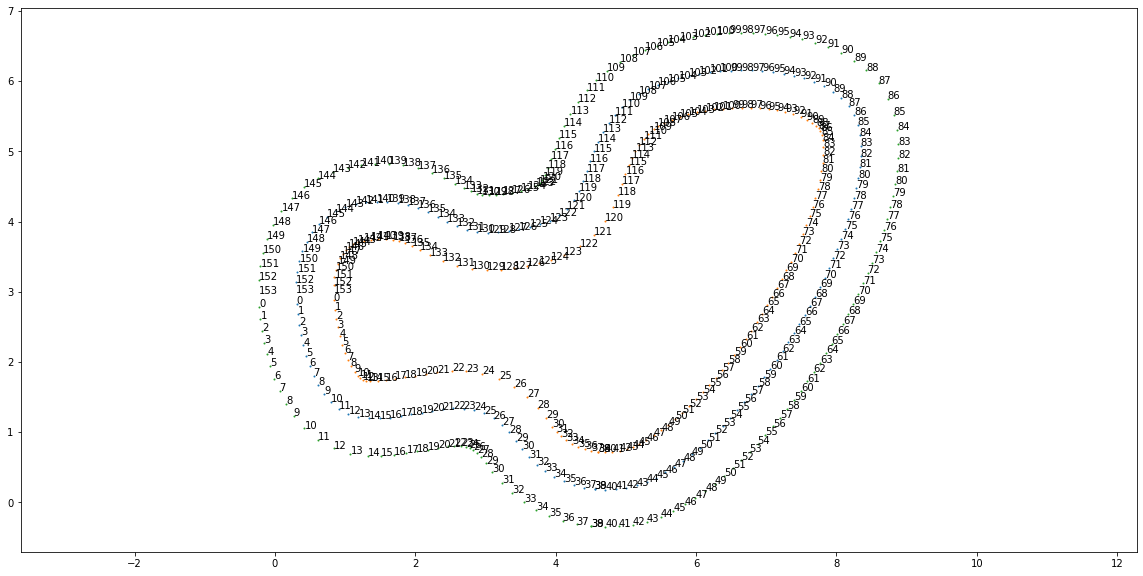

In [16]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

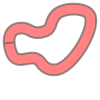

In [17]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [18]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# Helper Functions 

In [19]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0, scale=100):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    #track = np.zeros(track_size) # lets magnify the track by *100
    #for index, row in df.iterrows():
    #    x = int(row["x"]*scale + x_offset)
    #    y = int(row["y"]*scale + y_offset)
    #    reward = row["reward"]
    #    track[y, x] = reward
        #plt.plot(y,x,reward)
    allx=[]
    ally=[]
    allreward=[]
    for index, row in df.iterrows():
        x = float(row["x"])
        y = float(row["y"])
        reward = float(row["reward"])
        allx.append(x)
        ally.append(y)
        allrewards=reward
        #track[y, x] = reward
        #plt.plot(y,x,reward)
    heatmap, xedges, yedges = np.histogram2d(allx, ally, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return heatmap.T,extent

In [20]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

## Load the training log

Segment all steps into iterations of TRAINING_ITERATION episodes each.

In [21]:
TRAINING_ITERATION = 20

In [22]:
df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/TRAINING_ITERATION)+1) * TRAINING_ITERATION
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,iteration
0,0,1.0,0.322753,2.691312,-83.957889,0.0,0.666667,4,1.0,False,True,0.605961,1,23.118222,1.600111e+09,in_progress,1
1,0,2.0,0.323187,2.683938,-84.075600,0.0,1.000000,5,1.0,False,True,0.637880,1,23.118222,1.600111e+09,in_progress,1
2,0,3.0,0.324218,2.669842,-84.199656,30.0,1.000000,8,0.8,False,True,0.698867,1,23.118222,1.600111e+09,in_progress,1
3,0,4.0,0.327842,2.639445,-84.134692,-30.0,0.666667,1,0.8,False,True,0.831249,1,23.118222,1.600111e+09,in_progress,1
4,0,5.0,0.335557,2.593144,-83.502443,0.0,0.666667,4,1.0,False,True,1.034232,2,23.118222,1.600111e+09,in_progress,1


In [23]:
df['y'].min(), df['x'].max()

(-0.6005474024151305, 9.100939267371217)

In [24]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())


In [25]:
df['reward'].min(), df['reward'].max()

(0.0, 1.0)

## Plot rewards per Iteration

This graph is useful to understand the mean reward and standard deviation within each episode 

Number of episodes =  179


Text(0.5, 0, 'Episode')

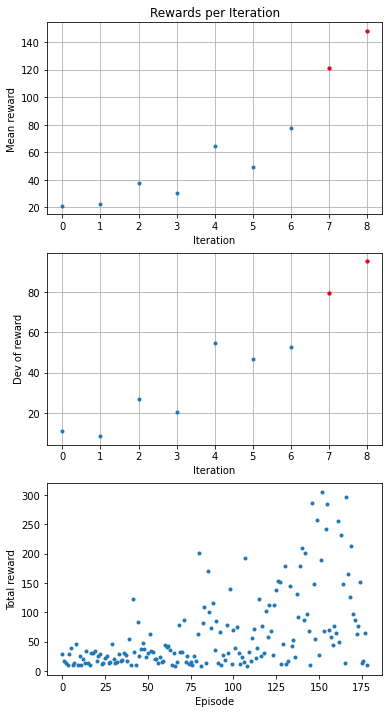

In [26]:
REWARD_THRESHOLD = 100

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == TRAINING_ITERATION - 1:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

## Analyze the reward distribution for your reward function

In [27]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis -0.4743526483902878; Max x-axis 9.100939267371217
Min y-axis -0.6005474024151305; Max y-axis 6.929992772976718


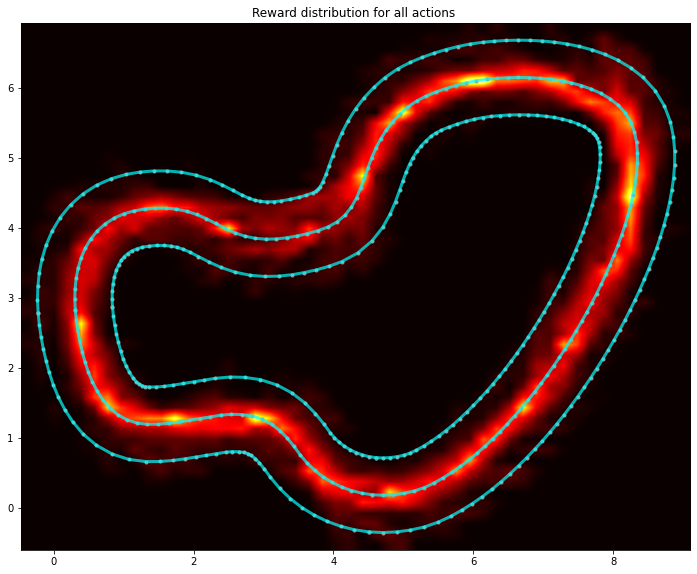

In [28]:
track,extent = plot_track(df, track_size=(10, 10), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Plot a particular iteration


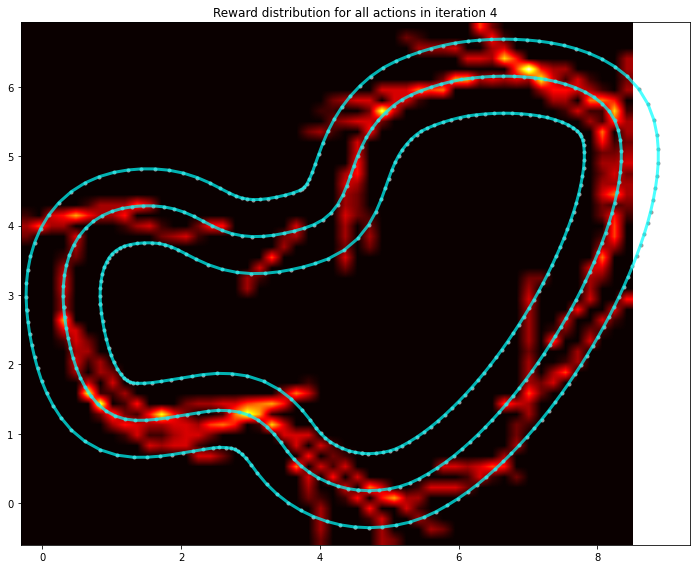

In [29]:
iteration_id = 4
track,extent = plot_track(df[df['iteration'] == iteration_id], track_size=(10, 10), x_offset=0, y_offset=0)
plt.title("Reward distribution for all actions in iteration "+str(iteration_id))
im = plt.imshow(track, cmap='hot', extent=extent, interpolation='bilinear', origin="lower") 

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

The top 3 highest reward episodes are [152, 166, 146]


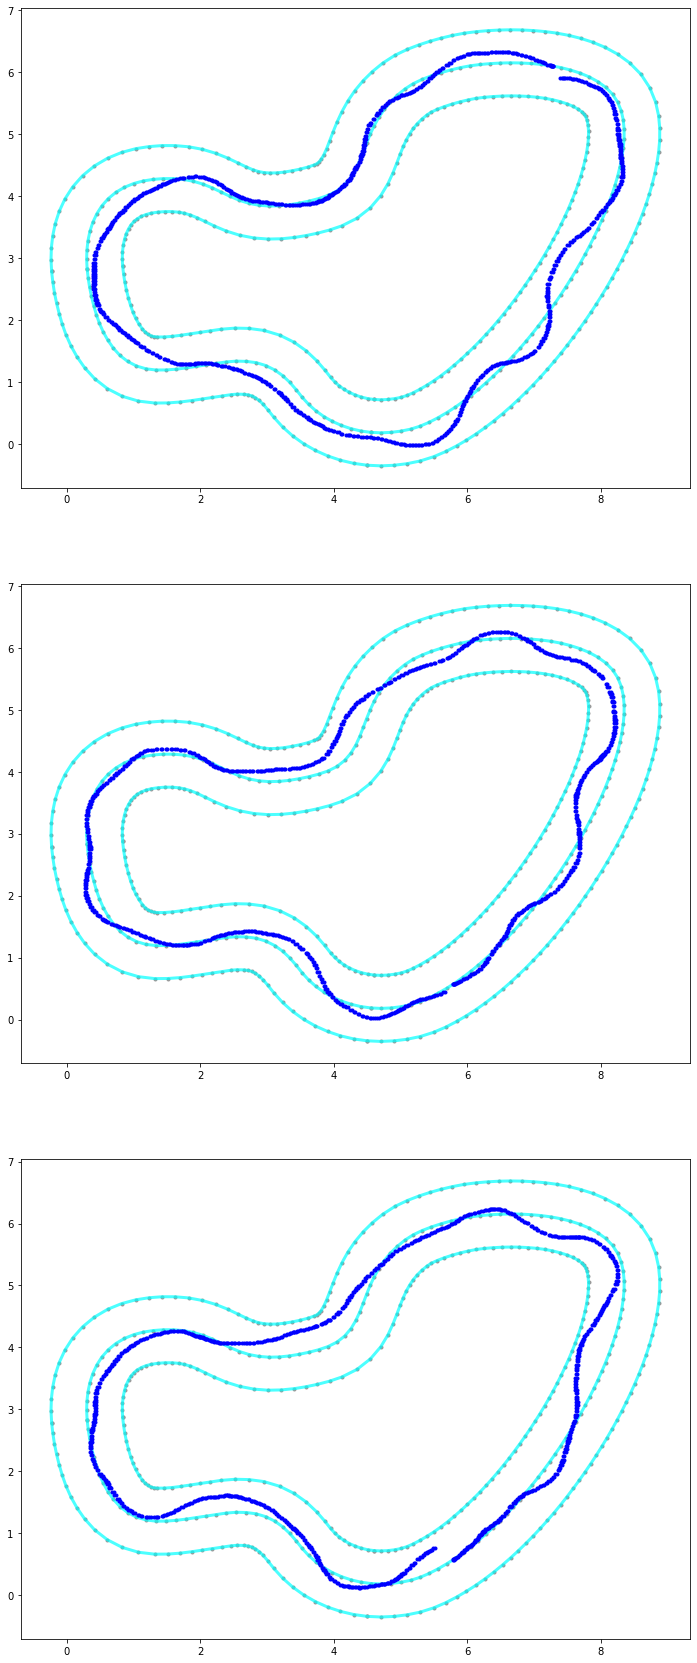

In [30]:
action_map, episode_map, sorted_idx = episode_parser(df)    
fig = plot_top_laps(sorted_idx[:], 3)
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

### Path taken in a particular episode

In [31]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

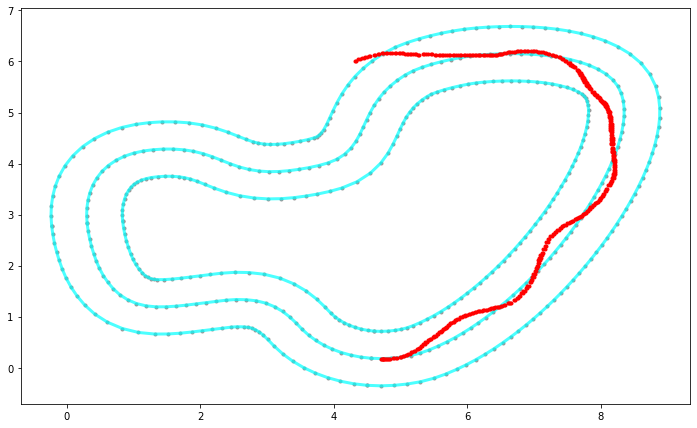

In [32]:
plot_episode_run(df, E=125) # arbitrary episode

### Path taken in a particular Iteration

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


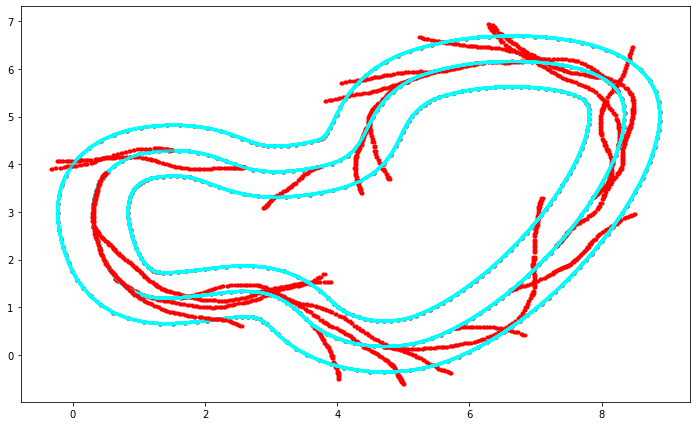

In [33]:
iteration_id = 4

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration.

** NOTE: This is only supported for reinvent track currently **

In [34]:
# Track Segment Labels
action_names = []
for action in model_metadata['action_space']:
    action_names.append("ST"+str(action['steering_angle'])+" SP"+"%.2f"%action["speed"])
action_names

['ST-30 SP0.33',
 'ST-30 SP0.67',
 'ST-30 SP1.00',
 'ST0 SP0.33',
 'ST0 SP0.67',
 'ST0 SP1.00',
 'ST30 SP0.33',
 'ST30 SP0.67',
 'ST30 SP1.00']

Number of steps in iteration= 1319


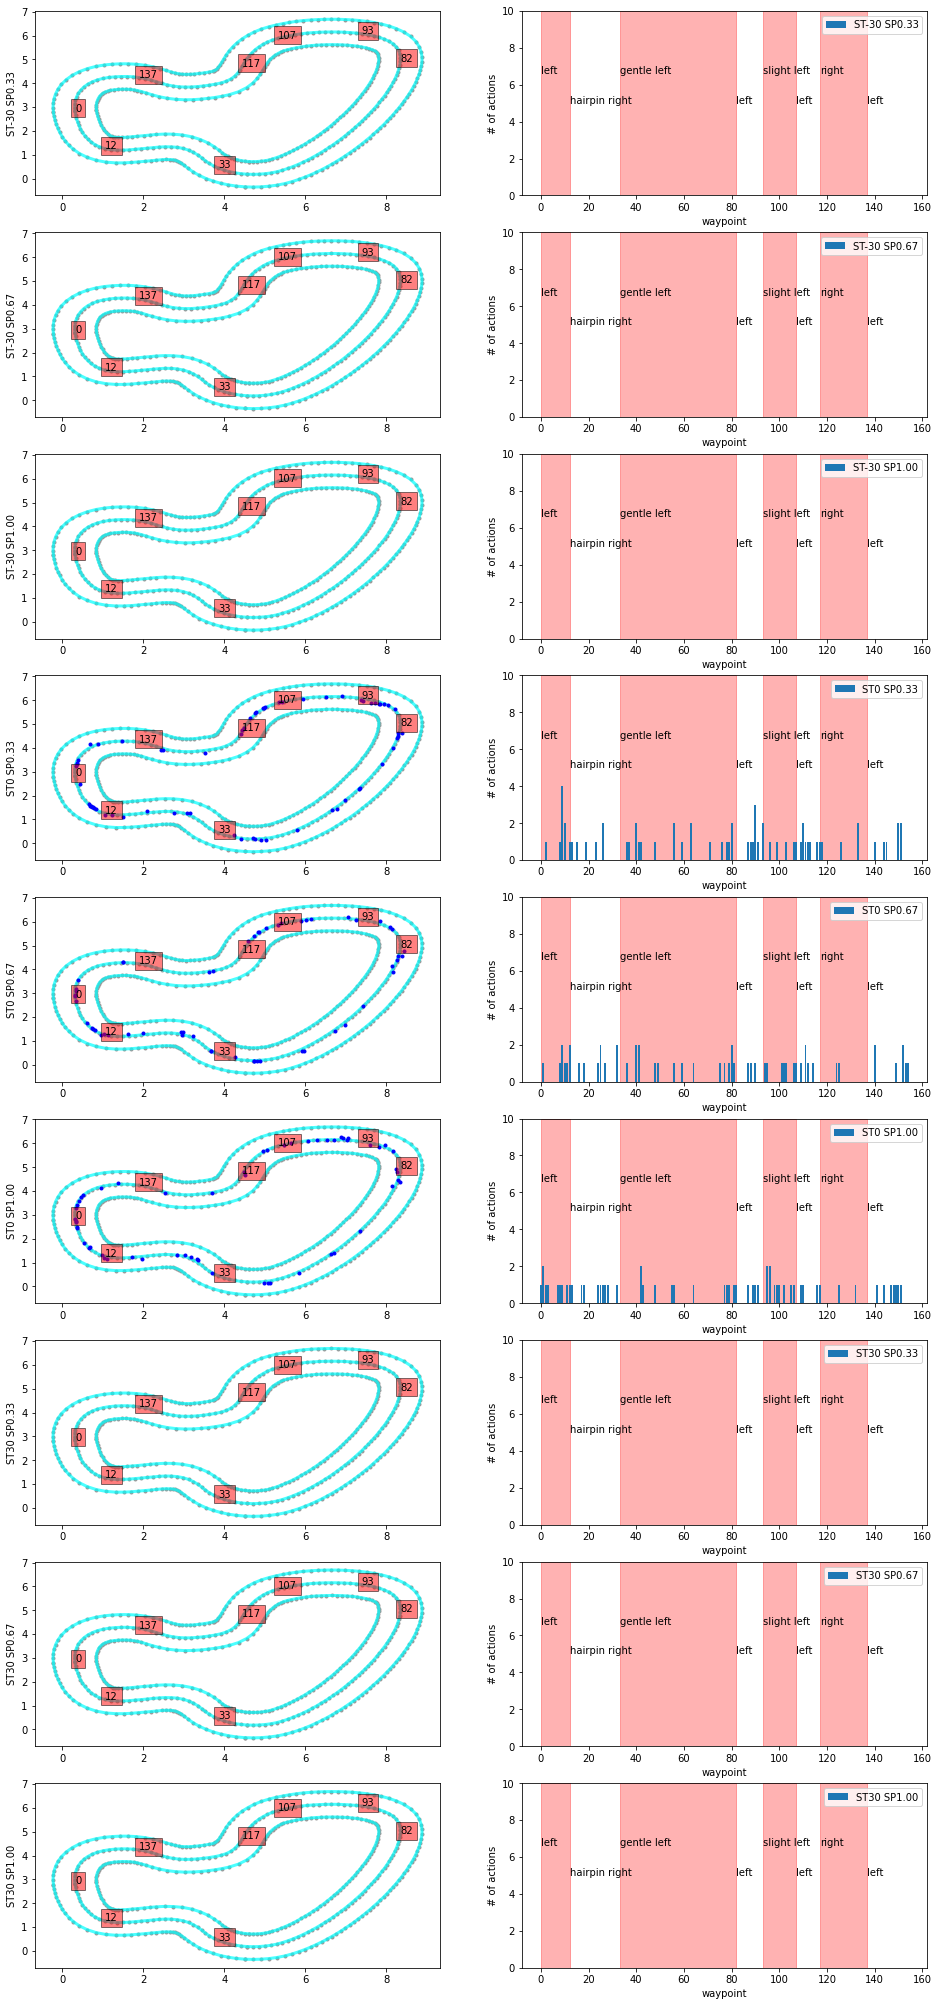

In [35]:
fig = plt.figure(figsize=(16, 4*len(action_names)))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

#action_names = ['LEFT', 'RIGHT', 'STRAIGHT', 'SLIGHT LEFT', 'SLIGHT RIGHT', 'SLOW']
vert_lines = [0,12,33,82,93,107,117,137]
y_limit = 10
track_segments = [(0, .66*y_limit, 'left'),
                  (12, .5*y_limit, 'hairpin right'),
                  (33, .66*y_limit, 'gentle left'),
                  (82, .5*y_limit, 'left'),
                  (93, .66*y_limit, 'slight left'),
                  (107, .5*y_limit, 'left'),
                  (117, .66*y_limit, 'right'),
                  (137, .5*y_limit, 'left')
                 ]
segment_x=[]
segment_y=[]
segment_xerr_l=[]
segment_xerr_r=[]
segment_yerr_n=[]
segment_yerr_s=[]
i=0
while i<len(vert_lines):
    segment_x.append(vert_lines[i])
    segment_y.append(0)
    segment_xerr_l.append(0)
    if i>len(vert_lines)-1:
        segment_xerr_r.append(len(waypoints)-vert_lines[i])
    else:
        segment_xerr_r.append(vert_lines[i+1]-vert_lines[i])
    segment_yerr_n.append(0)
    segment_yerr_s.append(y_limit)
    i+=2

segment_x = np.array(segment_x)
segment_y = np.array(segment_y)
segment_xerr = np.array([segment_xerr_l,segment_xerr_r])
segment_yerr = np.array([segment_yerr_n,segment_yerr_s])

#segment_x = np.array(vert_lines)
#segment_y = np.array([0]*len(vert_lines))
#segment_xerr = np.array([[0]*len(vert_lines),[1]*len(vert_lines)])
#segment_yerr = np.array([[0]*len(vert_lines), [150]*len(vert_lines)])

wpts_array = center_line 

for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    th = 0.8
    for idx in range(len(action_names)):
        ax = fig.add_subplot(len(action_names), 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in vert_lines:
            ax.text(wpts_array[idWp][0], wpts_array[idWp][1], str(idWp), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(len(action_names), 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)

        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], track_segments[tt][1], track_segments[tt][2])

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, y_limit))

Lets analyze the hairpin turn for the best iteration. We see that the model like to take Slight left and Straight over other actions, we see that slight right and right actions frequency is very low in comparison. In short, this model seems to do well for the hairpin turn 

## Simulation Image Analysis - Probability distribution on decisions (actions)

is the model making decisions that are "too close" or is it confident for the laps it finishes. if the top and second best decisions are far apart, the model must likely be making more confident decisions 

In [36]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

In [37]:
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
from PIL import Image

GRAPH_PB_PATH = 'intermediate_checkpoint/'+model_name+'/model'

def load_session(pb_path):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                    log_device_placement=True))
    print("load graph:", pb_path)
    with gfile.FastGFile(pb_path,'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    names = []
    for t in graph_nodes:
        names.append(t.name)
    
    # Different tensor names observation, 'FRONT_FACING_CAMERA', 'STEREO_CAMERAS'
    # For stereo cameras use the below
    # x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/STEREO_CAMERAS/STEREO_CAMERAS:0')
    # y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    # For front cameras use the below
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/FRONT_FACING_CAMERA/FRONT_FACING_CAMERA:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    
    return sess, x, y

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

This will show a list of the model checkpoints available for analysis

In [38]:
!ls $GRAPH_PB_PATH/*.pb

intermediate_checkpoint/origdeepracer/model/model_6.pb
intermediate_checkpoint/origdeepracer/model/model_7.pb
intermediate_checkpoint/origdeepracer/model/model_8.pb
intermediate_checkpoint/origdeepracer/model/model_9.pb


Update the 'iterations' variable below with the models of interest from the above list

In [39]:
model_inference = []
iterations = [6,7,8,9]

for ii in iterations:
    model_i, obs, model_out = load_session(GRAPH_PB_PATH + '/model_%i.pb'%(ii))
    arr = []
    for f in all_files[:]:
        img = Image.open(f)
        img_arr = np.array(img)
        img_arr = rgb2gray(img_arr)
        img_arr = np.expand_dims(img_arr, axis=2)
        current_state = {"observation": img_arr} #(1, 120, 160, 1)
        y_output = model_i.run(model_out, feed_dict={obs:[img_arr]})[0]
        arr.append (y_output)
        
    model_inference.append(arr)
    model_i.close()
    tf.reset_default_graph()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/origdeepracer/model/model_6.pb
Instructions for updating:
Use tf.gfile.GFile.
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/origdeepracer/model/model_7.pb
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/origdeepracer/model/model_8.pb
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/origdeepracer/model/model_9.pb


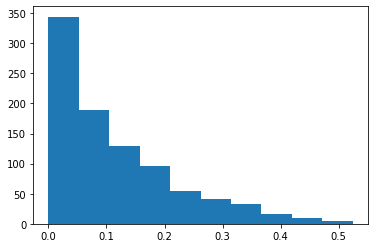

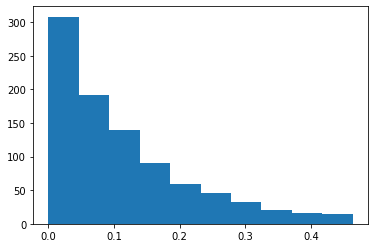

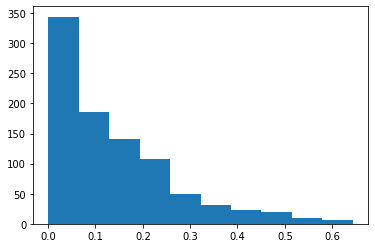

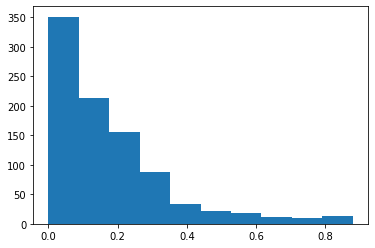

In [40]:
for model_i in model_inference:
    prob_diff = []
    for mi in model_i:
        max1, max2 = mi.argsort()[-2:][::-1]
        prob_diff.append(mi[max1] - mi[max2])
    plt.hist(prob_diff)
    plt.show()

Models with a better separation in probabability are likely to work better in sim2real experiments

# Model CSV Analysis


In [41]:
fname = 'intermediate_checkpoint/worker_0.multi_agent_graph.main_level.main_level.agent_0.csv'
df_csv = pd.read_csv(fname)

In [42]:
df_csv.columns

Index(['Episode #', 'Training Iter', 'Epoch', 'In Heatup', 'ER #Transitions',
       'ER #Episodes', 'Episode Length', 'Total steps', 'Epsilon',
       'Shaped Training Reward', 'Training Reward', 'Update Target Network',
       'Wall-Clock Time', 'Evaluation Reward', 'Shaped Evaluation Reward',
       'Success Rate', 'Inverse Propensity Score', 'Direct Method Reward',
       'Doubly Robust', 'Weighted Importance Sampling',
       'Sequential Doubly Robust', 'Loss/Mean', 'Loss/Stdev', 'Loss/Max',
       'Loss/Min', 'Learning Rate/Mean', 'Learning Rate/Stdev',
       'Learning Rate/Max', 'Learning Rate/Min', 'Grads (unclipped)/Mean',
       'Grads (unclipped)/Stdev', 'Grads (unclipped)/Max',
       'Grads (unclipped)/Min', 'Discounted Return/Mean',
       'Discounted Return/Stdev', 'Discounted Return/Max',
       'Discounted Return/Min', 'Entropy/Mean', 'Entropy/Stdev', 'Entropy/Max',
       'Entropy/Min', 'Advantages/Mean', 'Advantages/Stdev', 'Advantages/Max',
       'Advantages/Min',

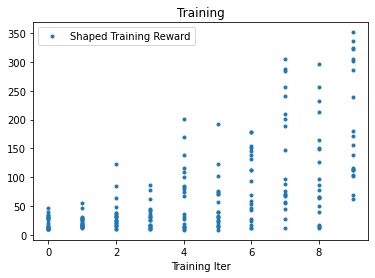

In [43]:
title = "Training"
df_csv.plot(x='Training Iter', y='Shaped Training Reward', style='.', 
        title=title)

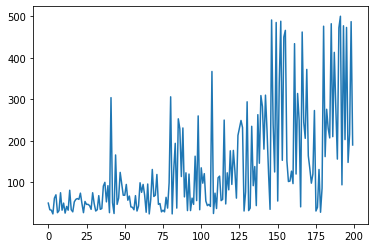

In [44]:
df_csv['Episode Length'].plot()

## Evaluation Run Analyis

Debug your evaluation runs or analyze the laps

In [45]:
model

{'ModelName': 'origdeepracer',
 'ModelArn': 'arn:aws:deepracer:us-east-1:011113936377:model/reinforcement_learning/origdeepracer',
 'WasImported': False,
 'WasMigrated': False,
 'CreatedInDataAccount': True,
 'CreationTime': 1600110258593,
 'ModelFramework': 'TENSOR_FLOW',
 'ModelArtifactS3Location': 's3://aws-deepracer-data-us-east-1-1/data-b59afc6f-6f89-4eff-8f0b-8b51f1f249fb/models/origdeepracer/sagemaker-artifacts/dr-sm-rltj--20200914190438-74b84570-7410-4a19-a13d-5df9a0e09dd5/output/model.tar.gz',
 'AgentAlgorithm': 'PPO',
 'AgentNetwork': 'SIX_LAYER_DOUBLE_HEAD_OUTPUT',
 'Status': 'READY',
 'CarConfiguration': {'ActionSpace': {'MaximumSteeringAngle': 30.0,
   'SteeringGranularity': 3,
   'MaximumSpeed': 1.0,
   'SpeedGranularity': 3},
  'NeuralNetwork': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
  'Sensors': ['FRONT_FACING_CAMERA']},
 'ModelPackagingComplete': True}

In [46]:
evaluation_job=dr_client.list_evaluations(ModelArn=model["ModelArn"],MaxResults=100)["EvaluationJobs"][0]
evaluation_log_url= dr_client.get_asset_url(Arn=evaluation_job['JobArn'], AssetType="LOGS")['Url']

with requests.get(evaluation_log_url, stream=True) as response:
    with open("{}-evallog.tar.gz".format(model_name), "wb") as tarball:
        for chunk in response.iter_content(16384):
            tarball.write(chunk)

#### Download simtrace from S3 eval metrics

In [47]:
!mkdir -p downloaded_model/{model_name}/evallogs 
!tar -zxf {model_name}-evallog.tar.gz -C ./downloaded_model/{model_name}/evallogs
eval_simtrace_path = !find ./downloaded_model/{model_name}/evallogs -name 0-iteration.csv

In [48]:
!tail -n 3 {eval_simtrace_path[0]}

2,525.0,0.5460261831405192,2.912914703508499,-105.18352726817443,30.0,0.6666666666666666,7,0.5,False,True,99.69152690824176,154,23.11822180235112,1600116353.6148026,in_progress
2,526.0,0.5360999111324469,2.8645457088750668,-104.52701519252649,30.0,0.3333333333333333,6,0.5,False,True,99.89856535957897,154,23.11822180235112,1600116353.6810765,in_progress
2,527.0,0.5333177350800684,2.8297379403187986,-103.06667409773748,0.0,0.3333333333333333,3,0.5,True,True,100,0,23.11822180235112,1600116353.7487292,lap_complete


In [49]:
eval_df = pd.read_csv(eval_simtrace_path[0])
iteration_arr = np.arange(math.ceil(eval_df.episode.max()/TRAINING_ITERATION)+1) * TRAINING_ITERATION
eval_df['iteration'] = np.digitize(eval_df.episode, iteration_arr)
eval_df = eval_df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
eval_df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,iteration
0,0,1.0,0.323817,3.188977,-92.447493,30.0,0.666667,7,1.0,False,True,-1.558200,152,23.118222,1.600116e+09,in_progress,1
1,0,2.0,0.323550,3.186768,-92.497381,30.0,0.666667,7,1.0,False,True,-1.548575,152,23.118222,1.600116e+09,in_progress,1
2,0,3.0,0.324130,3.173711,-92.240149,30.0,0.666667,7,1.0,False,True,-1.492665,152,23.118222,1.600116e+09,in_progress,1
3,0,4.0,0.325773,3.151765,-91.649811,-30.0,0.333333,0,1.0,False,True,-1.398997,152,23.118222,1.600116e+09,in_progress,1
4,0,5.0,0.327806,3.125369,-90.969332,-30.0,0.333333,0,1.0,False,True,-1.278669,152,23.118222,1.600116e+09,in_progress,1


## Grid World Analysis
    Understand the speed of the car along with the path on a per episode basis. This can help you debug portions of the track where the car may not be going fast. Hence giving you hints on how to improve your reward function.

Episode #0 
17 13
Outer polygon length = 105.87 (meters)
Inner polygon length = 79.07 (meters)
Distance, lap time = 0.23 (meters), 35.00 (sec)
Average throttle, velocity = 0.60 (Gazebo), 0.01 (meters/sec)
###############################################################


Episode #1 
17 13
Outer polygon length = 105.87 (meters)
Inner polygon length = 79.07 (meters)
Distance, lap time = 0.17 (meters), 24.95 (sec)
Average throttle, velocity = 0.65 (Gazebo), 0.01 (meters/sec)
###############################################################




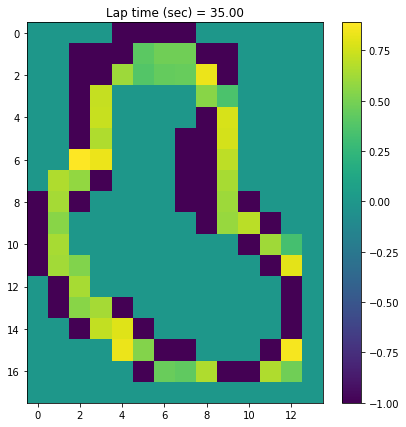

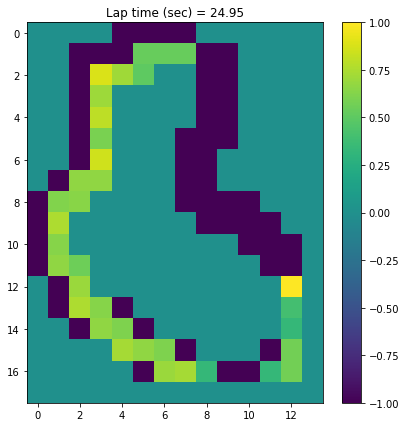

In [50]:
N_EPISODES = 2 
for e in range(N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = eval_df[eval_df['episode'] == e]
    plot_grid_world(episode_df, inner_border, outer_border, scale=0.5)
    print ("###############################################################\n\n")


## What is the model looking at?

Gradcam: visual heatmap of where the model is looking to make its decisions. based on https://arxiv.org/pdf/1610.02391.pdf

Note the tensors loaded below are based on the single camera DeepRacer; use of Evo will requirement adjustment to the code.

In [51]:
import cv2
import numpy as np
import tensorflow as tf

def visualize_gradcam_discrete_ppo(sess, rgb_img, category_index=0, num_of_actions=5):
    '''
    @inp: model session, RGB Image - np array, action_index, total number of actions 
    @return: overlayed heatmap
    '''
    
    img_arr = np.array(img)
    img_arr = rgb2gray(img_arr)
    img_arr = np.expand_dims(img_arr, axis=2)
    
    x = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_0/FRONT_FACING_CAMERA/FRONT_FACING_CAMERA:0')
    y = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    feed_dict = {x:[img_arr]}

    #Get he policy head for clipped ppo in coach
    model_out_layer = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/ppo_head_0/policy:0')
    loss = tf.multiply(model_out_layer, tf.one_hot([category_index], num_of_actions))
    reduced_loss = tf.reduce_sum(loss[0])
    
    # For front cameras use the below
    conv_output = sess.graph.get_tensor_by_name('main_level/agent/main/online/network_1/FRONT_FACING_CAMERA/Conv2d_4/Conv2D:0')
    
    grads = tf.gradients(reduced_loss, conv_output)[0]
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.sum(weights * output, axis=3)

    ##im_h, im_w = 120, 160##
    im_h, im_w = rgb_img.shape[:2]

    cam = cams[0] #img 0
    image = np.uint8(rgb_img[:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv2.resize(cam, (im_w, im_h)) # zoom heatmap
    cam = np.maximum(cam, 0) # relu clip
    heatmap = cam / np.max(cam) # normalize
    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # grayscale to color
    cam = np.float32(cam) + np.float32(image) # overlay heatmap
    cam = 255 * cam / (np.max(cam) + 1E-5) ##  Add expsilon for stability
    cam = np.uint8(cam)[:, :, ::-1] # to RGB

    return cam

In [52]:
import glob
img_path = "simulation_episode/"
all_files = sorted(glob.glob(img_path + '/*.png'))

Out of all the example images available, pick a random 10.

In [53]:
list_of_images=[]
for i in range(10):
    imagenum=random.randint(0,len(all_files)-1)
    list_of_images.append(all_files[imagenum])

In [54]:
model_path ='intermediate_checkpoint/agent/model.pb' #This is the frozen graph from the vehicle model

model, obs, model_out = load_session(model_path)
heatmaps = []
for f in list_of_images:
    img = np.array(Image.open(f))
    heatmap = visualize_gradcam_discrete_ppo(model, img, category_index=0, num_of_actions=len(model_metadata['action_space']))
    heatmaps.append(heatmap)
tf.reset_default_graph()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

load graph: intermediate_checkpoint/agent/model.pb


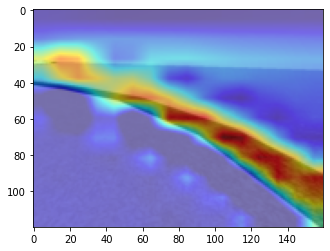

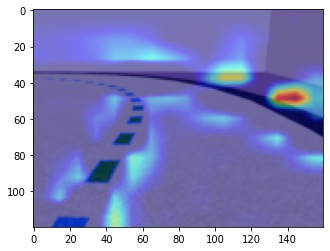

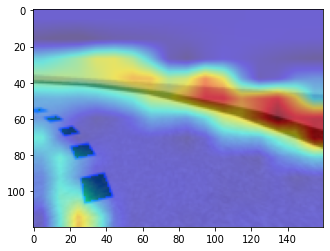

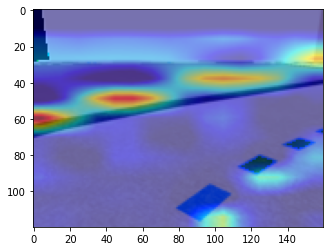

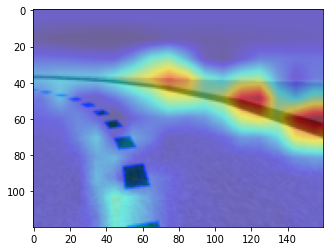

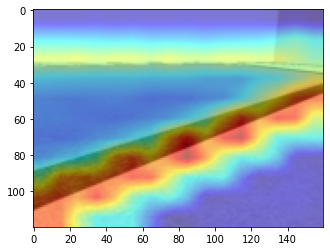

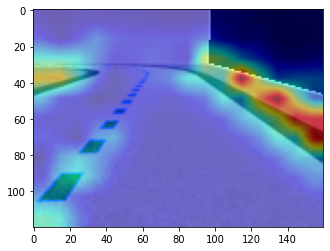

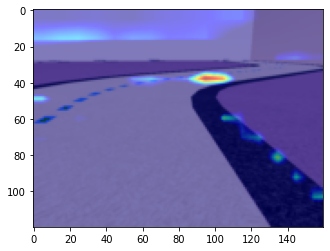

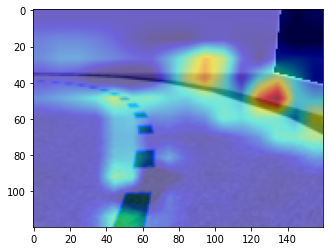

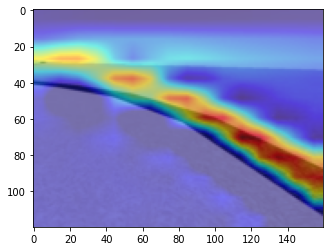

In [55]:
for heatmap in heatmaps:
    plt.imshow(heatmap)
    plt.show()